# MNIST Classification using Neural Network

Here we will build a neural-network classifier using PyTorch to classify hand-written digits images in MNIST dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler 
import torchvision.datasets as datasets
from torchvision import transforms 

## Download and pre-process data

In [5]:
# download train and test set
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
test_ds = datasets.MNIST(root='./data', download=True, train=False, transform=transform)

In [6]:
print(train_ds)
print(test_ds)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [7]:
# split train set into training (80%) and validation set (20%)
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]

In [8]:
len(train_idx), len(val_idx)

(48000, 12000)

In [9]:
# prepare dataloaders

train_sampler = sampler.SubsetRandomSampler(train_idx)
val_sampler = sampler.SubsetRandomSampler(val_idx)

train_dl = DataLoader(train_ds, batch_size=32, sampler=train_sampler)
val_dl = DataLoader(train_ds, batch_size=32, sampler=val_sampler)
test_dl = DataLoader(test_ds, batch_size=32)

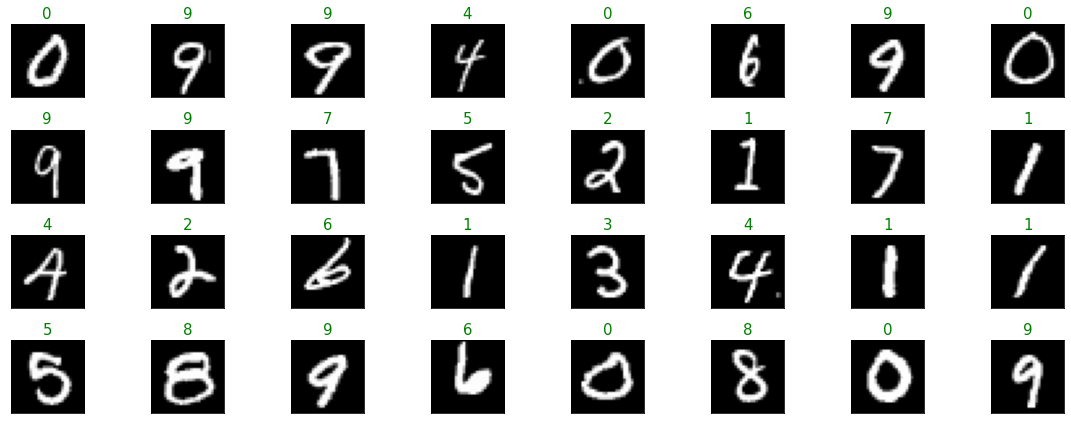

In [10]:
# display sample images from one train set batch 
single_batch = next((iter(train_dl)))
fig = plt.figure(figsize=(16, 6))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    image, label = single_batch[0][i].numpy().squeeze(), single_batch[1][i].numpy().squeeze()
    ax.imshow(image, cmap='gray')
    ax.set_title(label, fontsize=15, color='green')
plt.tight_layout()
plt.show()

## Define model architecture

In [11]:
# Model definition
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # first hidden layer: 784 x 256
        self.hidden_0 = nn.Linear(784, 128)
        self.hidden_1 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

        
    def forward(self, x):
        # flatten input to vector of 764
        x = x.view(x.shape[0], -1)
        # forward pass
        x = self.hidden_0(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden_1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [12]:
# Instantiate the model
model = Network()
model

Network(
  (hidden_0): Linear(in_features=784, out_features=128, bias=True)
  (hidden_1): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (activation): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [13]:
# Define loss-function and optimizer
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train and validate model

In [14]:
# Setup available device and move model to the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(f'Moving `model` to [{device}] for training...')

Moving `model` to [cuda] for training...


In [15]:
n_epochs = 10
train_losses = []
val_losses = []
min_val_loss = np.Inf
for epoch in range(1, n_epochs+1):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    ###################
    # Training loop   #
    ###################
    model.train()
    for inputs, labels in train_dl:
        # move data to `device` where model resides
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass for this batch
        outputs = model(inputs)
        # compute training batch loss
        loss = loss_fn(outputs, labels)
        # reset gradients
        optimizer.zero_grad()
        # back-propogation
        loss.backward()
        # update weights
        optimizer.step()
        # keep track of loss incurred for each training batch
        epoch_train_loss += loss.item()
        
    ###################
    # Validation loop #
    ###################
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dl:
            # move data to `device` where model resides
            inputs, labels = inputs.to(device), labels.to(device)
            # forward pass for this batch
            outputs = model(inputs)
            # compute batch validation loss
            loss = loss_fn(outputs, labels)
            # keep track of loss incurred for each validation batch
            epoch_val_loss += loss.item()

        # compute training and validation loss incurred for this epoch
        epoch_train_loss = epoch_train_loss/len(train_dl)
        epoch_val_loss = epoch_val_loss/len(val_dl)
        # store losses for each epoch for plotting later on
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # print training and validation stats
        print(f'Epoch {epoch}/{n_epochs}: train_loss = {epoch_train_loss:.8f}\tval_loss = {epoch_val_loss:.8f}')

        # save the model if validation loss improved
        if epoch_val_loss < min_val_loss:
            print(f'val_loss decreased ({min_val_loss:.8f}) --> ({epoch_val_loss:.8f}). Saving this model...')
            torch.save(model.state_dict(), 'MNIST_model.pth')
            min_val_loss = epoch_val_loss 

Epoch 1/10: train_loss = 0.42168129	val_loss = 0.18413437
val_loss decreased (inf) --> (0.18413437). Saving this model...
Epoch 2/10: train_loss = 0.19993354	val_loss = 0.14096548
val_loss decreased (0.18413437) --> (0.14096548). Saving this model...
Epoch 3/10: train_loss = 0.15446039	val_loss = 0.11732115
val_loss decreased (0.14096548) --> (0.11732115). Saving this model...
Epoch 4/10: train_loss = 0.13179579	val_loss = 0.10580321
val_loss decreased (0.11732115) --> (0.10580321). Saving this model...
Epoch 5/10: train_loss = 0.11377260	val_loss = 0.10300163
val_loss decreased (0.10580321) --> (0.10300163). Saving this model...
Epoch 6/10: train_loss = 0.10256227	val_loss = 0.10413443
Epoch 7/10: train_loss = 0.09504719	val_loss = 0.09914416
val_loss decreased (0.10300163) --> (0.09914416). Saving this model...
Epoch 8/10: train_loss = 0.08870372	val_loss = 0.09507103
val_loss decreased (0.09914416) --> (0.09507103). Saving this model...
Epoch 9/10: train_loss = 0.08475889	val_loss =

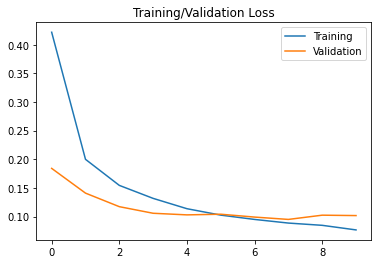

In [18]:
# Plot loasses
plt.title('Training/Validation Loss')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()

## Test the trained model

In [19]:
# Load model with the trained wights
weights = torch.load('MNIST_model.pth')
model = Network()
model.load_state_dict(weights)

# define loss function for computing test losses
loss_fn = nn.NLLLoss()

# move model to available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [20]:
# test the model on unseen data
model.eval()
test_loss = 0.0
test_acc = 0.0
correct_count = {i:0 for i in range(10)} # keep track of correct prediction of each class
total_count = {i:0 for i in range(10)}   # keep track of total occurances of each class
with torch.no_grad():
    for images, labels in test_dl:
        # move data to device
        images, labels = images.to(device), labels.to(device)
        # make prediction
        outputs = model(images) 
        pred_labels_proba = torch.exp(outputs) # last layer outputs `log_softmax` hence `exp` required
        # compute batch loss and keep track of running loss
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        # compute batch accuracy and keep track of running accuracy
        _, pred_labels = torch.max(pred_labels_proba, dim=1) # predicted class is with maximum probability
        correct_preds = labels == pred_labels.squeeze()      # squeeze is required becuase pred_classes has 2 dims
        test_acc += correct_preds.sum(dim=0)/len(correct_preds)
        # keep track of correct prediction and total count of each class
        for i, label in enumerate(labels):
            label = label.item()
            total_count[label] += 1
            correct_count[label] += correct_preds.to('cpu').numpy()[i]
    
# compute overall test loss and test accuracy
test_loss = test_loss/len(test_dl)
test_acc = test_acc/len(test_dl) * 100

# print overall test statistics
print(f'overall test_loss = {test_loss:.8f}\noverall test_acc  = {test_acc:.2f}%\n')
# print 
for i, digit in enumerate(correct_count):
    print(f'label {digit}: {correct_count[digit]}/{total_count[digit]}\t(accuracy = {correct_count[digit]/total_count[digit]:.2f}%)')

overall test_loss = 0.08329301
overall test_acc  = 97.52%

label 0: 965/980	(accuracy = 0.98%)
label 1: 1130/1135	(accuracy = 1.00%)
label 2: 1000/1032	(accuracy = 0.97%)
label 3: 982/1010	(accuracy = 0.97%)
label 4: 963/982	(accuracy = 0.98%)
label 5: 867/892	(accuracy = 0.97%)
label 6: 943/958	(accuracy = 0.98%)
label 7: 999/1028	(accuracy = 0.97%)
label 8: 932/974	(accuracy = 0.96%)
label 9: 971/1009	(accuracy = 0.96%)


## Predict single data point

In [21]:
# Load model with the trained wights
weights = torch.load('MNIST_model.pth')
model = Network()
model.load_state_dict(weights)

# move model to the available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

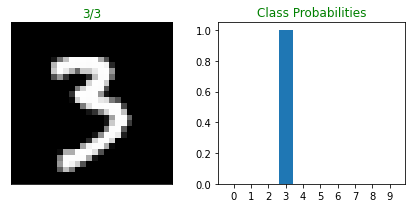

In [22]:
# make prediction
model.eval()
with torch.no_grad():
    # get a single image
    batch = next(iter(test_dl))
    img_idx = 30
    image, label = batch[0][img_idx].to(device), batch[1][img_idx].to(device)
    # predict
    proba = torch.exp(model(image))
    _, pred_label = torch.max(proba, dim=1)
    
# plot image
fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
image = image.squeeze().to('cpu').numpy() # remove first dim, move it to cpu and make it a numpy array
ax1.imshow(image, cmap='gray')
ax1.set_title(f'{pred_label.item()}/{label.item()}', color='green')

# plot predicted probabilities
proba = proba.squeeze().to('cpu').numpy() # remove first dim, move it to cpu and make it a numpy array
ax2 = fig.add_subplot(1, 2, 2) 
labels = [str(i) for i in range(10)]
ax2.bar(range(len(labels)), proba)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels)
ax2.set_title(f'Class Probabilities', color='green')
plt.tight_layout()
plt.show()